In [57]:
import pdb
from nltk.corpus import stopwords, twitter_samples
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from os import getcwd
import re

In [58]:

# Función típica de limpieza reutilizada

def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks    
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [59]:
datos_1 = pd.read_csv("Spam para Naive Bayes\completeSpamAssassin.csv")
datos_2 = pd.read_csv("Spam para Naive Bayes/enronSpamSubset.csv")
datos_3 = pd.read_csv("Spam para Naive Bayes\lingSpam.csv")

In [60]:
datos_1.head(5)

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [61]:
datos_1.drop("Unnamed: 0",inplace=True,axis=1)
datos_2.drop(["Unnamed: 0","Unnamed: 0.1"],inplace=True,axis=1)
datos_3.drop("Unnamed: 0",inplace=True,axis=1)

In [62]:
datos = pd.concat([datos_1,datos_2,datos_3],axis=0)
datos.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


Limpiamos los datos con la función de preprocesamiento 

In [63]:
# Tarda en procesar, el dataset es bastante grande
# Asegurarse de que la columna 'Body' sea de tipo cadena de texto
datos['Body'] = datos['Body'].astype(str)


datos['Processed'] = datos['Body'].apply(process_tweet)

# Mostrar el DataFrame resultante
print(datos.head())

                                                Body  Label  \
0  \nSave up to 70% on Life Insurance.\nWhy Spend...      1   
1  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1   
2  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1   
3  ##############################################...      1   
4  I thought you might like these:\n1) Slim Down ...      1   

                                           Processed  
0  [save, 70, life, insur, spend, life, quot, sav...  
1  [1, fight, risk, cancer, slim, guarante, lose,...  
2  [1, fight, risk, cancer, slim, guarante, lose,...  
3  [adult, club, offer, free, membership, instant...  
4  [thought, might, like, 1, slim, guarante, lose...  


In [64]:
datos_validos = datos["Processed"]
datos_validos.shape

(18651,)

In [65]:
datos_validos.head()

0    [save, 70, life, insur, spend, life, quot, sav...
1    [1, fight, risk, cancer, slim, guarante, lose,...
2    [1, fight, risk, cancer, slim, guarante, lose,...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, 1, slim, guarante, lose...
Name: Processed, dtype: object

In [66]:
from sklearn.feature_extraction.text import CountVectorizer

# Crear una instancia del vectorizador
vectorizer = CountVectorizer(max_features=20000)

# Aplicar el vectorizador a la columna 'Processed'
x = vectorizer.fit_transform([" ".join(text) for text in datos_validos]).toarray()


In [67]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,np.asarray(datos["Label"]),random_state=42,test_size=0.2)
x_train.shape

(14920, 20000)

Ya está, ya podemos ajustar el modelo

In [68]:
import time
inicio = time.time()
NB = GaussianNB()
NB.fit(x_train,y_train)
fin = time.time()

print(round(fin-inicio,2))

21.09


In [69]:
NB.score(x_test,y_test)


0.8405253283302064

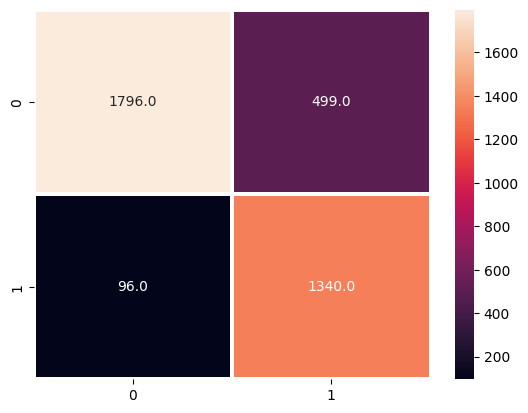

In [70]:
from sklearn.metrics import confusion_matrix
y_pred = NB.predict(x_test)

conf = confusion_matrix(y_pred=y_pred,y_true=y_test)
import seaborn
seaborn.heatmap(conf,annot=True,fmt=".1f",linewidths=1.5)
import matplotlib.pyplot as plt
plt.show()

Voy a guardar el modelo como un pickle para mayor comodidad

Por último vamos a predecir un Email

In [71]:
def procesar_correo(correo):
    """Función para procesar correos electrónicos.
    Entrada:
        correo: una cadena de texto que contiene el correo electrónico
    Salida:
        correo_limpio: una lista de palabras que contiene el correo procesado
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # Eliminar etiquetas de mercado de valores como $GE
    correo = re.sub(r'\$\w*', '', correo)
    # Eliminar texto de retweets al estilo antiguo "RT"
    correo = re.sub(r'^RT[\s]+', '', correo)
    # Eliminar hiperenlaces    
    correo = re.sub(r'https?://[^\s\n\r]+', '', correo)
    # Eliminar hashtags
    # solo se elimina el símbolo # de la palabra
    correo = re.sub(r'#', '', correo)
    # Tokenizar correos electrónicos
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tokens_correo = tokenizer.tokenize(correo)

    correo_limpio = []
    for palabra in tokens_correo:
        if (palabra not in stopwords_english and  # eliminar palabras vacías
                palabra not in string.punctuation):  # eliminar puntuación
            palabra_raiz = stemmer.stem(palabra)  # obtención de la raíz de la palabra
            correo_limpio.append(palabra_raiz)

    return ' '.join(correo_limpio)  # Convertir la lista de palabras de nuevo en una cadena de texto




In [72]:
import pickle

# Cargar el modelo y el vectorizador
model = pickle.load(open("model.pckl", mode="rb"))
vectorizer = pickle.load(open("vectorizer.pckl", mode="rb"))

# Definir la función para predecir el correo
def predecir_correo(correo):
    correo_procesado = procesar_correo(correo)
    vector = vectorizer.transform([correo_procesado]).toarray()
    decision = model.predict(vector)
    if decision[0] == 1:
        return "spam"
    else:
        return "no spam"


spam


In [73]:
# Llamar a la función para predecir el correo
resultado = predecir_correo("Dear Mr./ Miss. / Mrs.I am a professional with a wide experience in Foreign languages. I am writing to let you know I am very interested in working at your High school as an English teacher. I have more than 10 years experience in the field and now, I want to join a school such as yours, with a program that fits my mindset and background.")
print(resultado)

spam
